In [1]:
import numpy as np
import pandas as pd
import math
import random
import datetime as dt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
mg = pd.read_csv("./MG_dataset.csv", header=None)
mg.head()

,0
0,1.20000
1,1.08580
2,0.98248
3,0.88898
4,0.80438


In [3]:
mg.rename(columns={0: "values"}, inplace=True)
mg.head()

,values
0,1.20000
1,1.08580
2,0.98248
3,0.88898
4,0.80438


<Axes: >

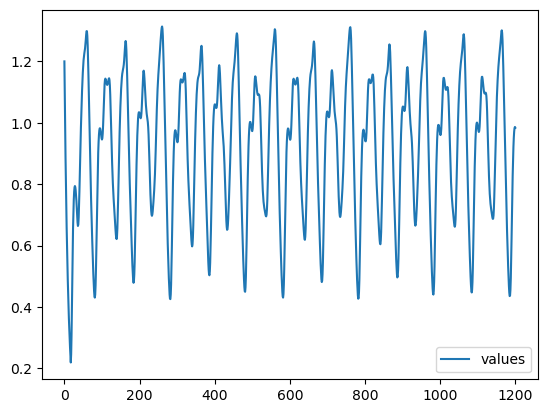

In [4]:
mg.plot()

In [5]:
decompose = seasonal_decompose(mg['values'], model='additive', period=50)
estimated_trend = decompose.trend
estimated_seasonal = decompose.seasonal
estimated_residual = decompose.resid

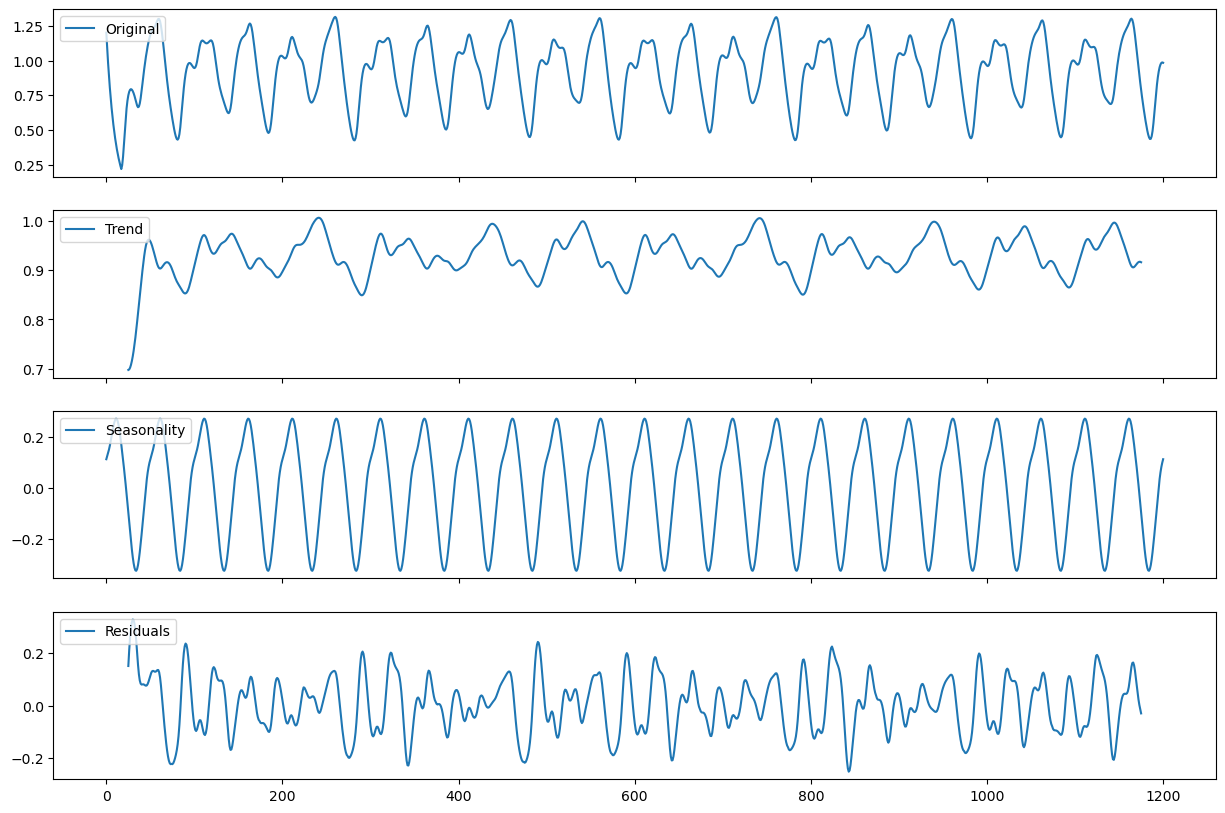

In [6]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(mg, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

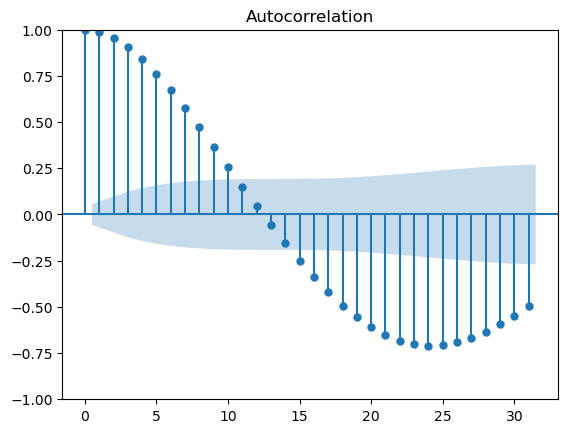

In [7]:
plot_acf(mg)
plt.show()

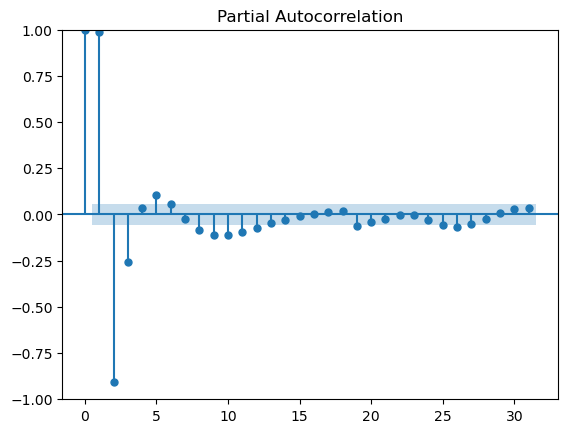

In [8]:
plot_pacf(mg)
plt.show()

In [9]:
adf_result = adfuller(mg)
print("ADF Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

# KPSS Test
kpss_result = kpss(mg, regression='c')  # 'c' for constant, 'ct' for constant and trend
print("\nKPSS Test Results:")
print(f"KPSS Statistic: {kpss_result[0]}")
print(f"p-value: {kpss_result[1]}")
print(f"Critical Values: {kpss_result[3]}")

ADF Test Results:
ADF Statistic: -10.654320001648962
p-value: 4.575667321762772e-19
Critical Values: {'1%': -3.435913333460925, '5%': -2.863996640985854, '10%': -2.5680779665111078}

KPSS Test Results:
KPSS Statistic: 0.04634764986010854
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [10]:
# Configuraciones para los modelos SARIMAX
sarimax_configs = [
    {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12)},  # Configuración 1
    {'order': (2, 1, 2), 'seasonal_order': (1, 0, 1, 12)},  # Configuración 2
    {'order': (3, 0, 0), 'seasonal_order': (0, 1, 1, 12)},  # Configuración 3
    {'order': (1, 0, 1), 'seasonal_order': (1, 1, 0, 12)}   # Configuración 4
]

In [11]:
train_size = int(len(mg) * 0.9)

train_data = mg['values'].iloc[:train_size]
test_data = mg['values'].iloc[train_size:]

In [12]:
best_model = None
best_config = None
best_mae = float('inf')  # Inicializamos con un valor muy alto para MAE
best_rmse = float('inf') 

# Asumimos que 'data' contiene la serie temporal
results = []

for config in sarimax_configs:
    print(f"Evaluando configuración: {config}")
    
    # Crear y entrenar el modelo
    model = SARIMAX(train_data, 
                    order=config['order'], 
                    seasonal_order=config['seasonal_order'])
    fitted_model = model.fit(disp=False)
    
    # Generar predicciones en el conjunto de entrenamiento
    # Aquí se utiliza el rango de las predicciones, desde el inicio del conjunto de prueba hasta el final
    predictions = fitted_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    
    # Calcular métricas de error
    mae = mean_absolute_error(test_data, predictions)
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    
    # Almacenar resultados
    results.append({
        'config': config,
        'model': fitted_model,
        'mae': mae,
        'rmse': rmse
    })

    if mae < best_mae:  # Si el modelo actual tiene menor MAE
        best_mae = mae
        best_rmse = rmse
        best_model = fitted_model
        best_config = config

    print(f"MAE: {mae}, RMSE: {rmse}")

Evaluando configuración: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12)}
MAE: 3.575675395901875, RMSE: 4.1083766396233345
Evaluando configuración: {'order': (2, 1, 2), 'seasonal_order': (1, 0, 1, 12)}
MAE: 0.3815676096931517, RMSE: 0.44106794612361105
Evaluando configuración: {'order': (3, 0, 0), 'seasonal_order': (0, 1, 1, 12)}
MAE: 0.46186687423772055, RMSE: 0.5256030835222062
Evaluando configuración: {'order': (1, 0, 1), 'seasonal_order': (1, 1, 0, 12)}
MAE: 1.594899371017771, RMSE: 1.7189960607574


In [13]:
for result in results:
    print(f"Config: {result['config']}, MAE: {result['mae']:.2f}, RMSE: {result['rmse']:.2f}")

Config: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12)}, MAE: 3.58, RMSE: 4.11
Config: {'order': (2, 1, 2), 'seasonal_order': (1, 0, 1, 12)}, MAE: 0.38, RMSE: 0.44
Config: {'order': (3, 0, 0), 'seasonal_order': (0, 1, 1, 12)}, MAE: 0.46, RMSE: 0.53
Config: {'order': (1, 0, 1), 'seasonal_order': (1, 1, 0, 12)}, MAE: 1.59, RMSE: 1.72


In [14]:
print(f"Best order: {best_config['order']}, Best seasonal order: {best_config['seasonal_order']}")

Best order: (2, 1, 2), Best seasonal order: (1, 0, 1, 12)


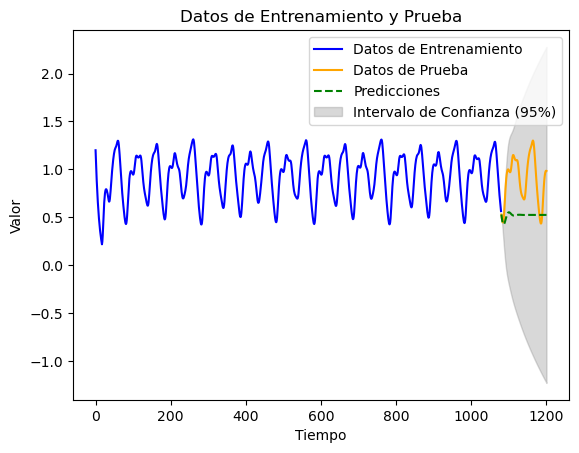

In [15]:
train_index = train_data.index
test_index = test_data.index

# Graficar los datos de entrenamiento en color azul
plt.plot(train_index, train_data, label="Datos de Entrenamiento", color='blue')

# Graficar los datos de prueba en color naranja
plt.plot(test_index, test_data, label="Datos de Prueba", color='orange')

model = SARIMAX(train_data, order=best_config['order'], seasonal_order=best_config['seasonal_order'])
fitted_model = model.fit(disp=False)

# Generar las predicciones con sus intervalos de confianza usando get_forecast
forecast_steps = len(test_data)
forecast = fitted_model.get_forecast(steps=forecast_steps)
predictions = forecast.predicted_mean
conf_int = forecast.conf_int()

# Graficar las predicciones con el intervalo de confianza
plt.plot(test_index, predictions, label="Predicciones", color='green', linestyle='--')

# Graficar los intervalos de confianza como área sombreada
plt.fill_between(test_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="Intervalo de Confianza (95%)")
# Opcionalmente, puedes agregar títulos y etiquetas
plt.title("Datos de Entrenamiento y Prueba")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()

plt.show()

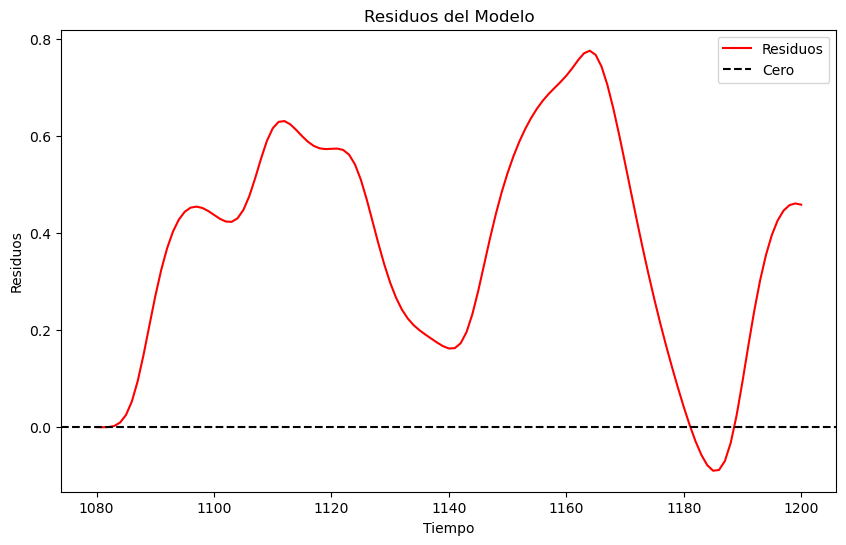

In [16]:
residuals = test_data - predictions

plt.figure(figsize=(10, 6))
plt.plot(test_index, residuals, label="Residuos", color='red')
plt.axhline(y=0, color='black', linestyle='--', label="Cero")
plt.title("Residuos del Modelo")
plt.xlabel("Tiempo")
plt.ylabel("Residuos")
plt.legend()
plt.show()

## Deep learning

In [18]:
def create_dataset(data, n_input, n_output):
    X, y = [], []
    for i in range(len(data) - n_input - n_output + 1):
        # Secuencia de entrada de tamaño n_input
        X.append(data[i:i+n_input])
        # Secuencia de salida (predicción) de tamaño n_output
        y.append(data[i+n_input:i+n_input+n_output])
    return np.array(X), np.array(y)

In [19]:
configs = [
    {'input_steps': 2, 'forecast_steps': 1},
    {'input_steps': 2, 'forecast_steps': 2},
    {'input_steps': 4, 'forecast_steps': 1},
    {'input_steps': 4, 'forecast_steps': 2}
]

Evaluando configuración: {'input_steps': 2, 'forecast_steps': 1}
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
MAE: 0.0158821271752109, RMSE: 0.01864846350482568


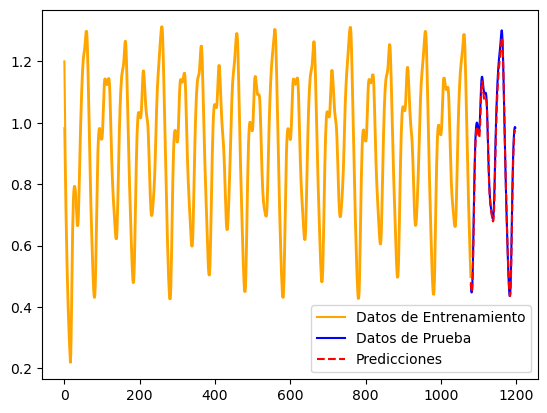

Evaluando configuración: {'input_steps': 2, 'forecast_steps': 2}
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


ValueError: y_true and y_pred have different number of output (2!=1)

In [20]:
for config in configs:
    print(f"Evaluando configuración: {config}")
    X, y = create_dataset(mg['values'], config['input_steps'], config['forecast_steps'])
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model_lstm = Sequential()

    model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(config['input_steps'],1)))
    model_lstm.add(Dropout(0.4))
    model_lstm.add(LSTM(units=50, return_sequences=True))
    model_lstm.add(Dropout(0.4))
    model_lstm.add(LSTM(units=50, return_sequences=False))
    model_lstm.add(Dropout(0.4))
    model_lstm.add(Dense(units=1))

    model_lstm.compile(loss='mean_squared_error', optimizer='adam')

    model_lstm.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

    predictions = model_lstm.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"MAE: {mae}, RMSE: {rmse}")

    
    # Graficar los resultados
    plt.plot(range(len(X_train)), X_train[:, 0], label="Datos de Entrenamiento", color='orange')
    plt.plot(range(len(y_train)), y_train[:, 0], color='orange')
    # Graficar los datos de prueba
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test[:, 0], label="Datos de Prueba", color='blue')
    # Graficar las predicciones
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), predictions[:, 0], label="Predicciones", color='red', linestyle='--')
    plt.legend()
    plt.show()